In [26]:
import os, json
import pandas as pd
import numpy as np
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
total_data = []
filepath = '../infer_res/llama2_13b_lora_0217_merge.json'
with open(filepath) as f:
    for line in f:
        dic = json.loads(line)
        for d in dic['details']:
            d['prob'] = np.exp(d.pop('logprob'))
        total_data.append(dic)
print(len(total_data))

2700


In [28]:
total_data[0]
keys = ['id', 'source_id', 'input_str', 'response', 'model', 'task_type', 'labels', 'output', 'details']
save_data = []
for dic in total_data:
    new_dic = {}
    for k in keys:
        new_dic[k] = dic[k]
    save_data.append(new_dic)
df = pd.DataFrame(save_data)
df.to_csv('../infer_res/llama2_13b_lora_0217_merge.csv')
print(df.shape)

(2700, 9)


In [29]:
for dic in total_data:
    # for d in dic['details']:
    #     d['prob'] = np.exp(d['logprob'])
    if dic['id'] == '15737':
        print(json.dumps(dic, indent=2))

{
  "id": "15737",
  "source_id": "15543",
  "model": "llama-2-70b-chat",
  "temperature": 0.85,
  "labels": [],
  "split": "test",
  "quality": "good",
  "response": "The average temperature for Tallahassee, Florida is 79 degrees Fahrenheit (26 degrees Celsius) high and 56 degrees Fahrenheit (13 degrees Celsius) low.",
  "source_info": {
    "question": "temperature for tallahassee florida",
    "passages": "passage 1:Because it is one of Florida's northernmost cities, Tallahassee has an overall average high temperature of just 79 degrees and an average low of only 56 degrees, making it an ideal vacation destination year-round.\n\npassage 2:\u00b0C | \u00b0F. Climate data for tallahassee municipal ap, Longitude: -84.3533, Latitude: 30.3931. Average weather Tallahassee, FL - 32310 - 1981-2010 normals. Jan: January, Feb: February, Mar: March, Apr: April, May: May, Jun: June, Jul: July, Aug: August, Sep: September, Oct: October, Nov: November, Dec: December.\n\npassage 3:How Often Tallah

# 计算一下假阳/真阳性前两个token的概率密度

In [36]:
fp_dic = {'first': [], 'second': []}
tp_dic = {'first': [], 'second': []}
tn_dic = {'first': [], 'second': []}
fn_dic = {'first': [], 'second': []}
tp, fp, tn, fn = 0, 0, 0, 0
for dic in total_data:
    output = literal_eval(dic['output'])
    labels = dic['labels']
    details = dic['details']
    first_token_prob = details[0]['prob']
    second_token_prob = details[1]['prob']
    if len(output) >0 and len(labels) == 0:
        fp_dic['first'].append(first_token_prob)
        fp_dic['second'].append(second_token_prob)
        fp += 1
    elif len(output) > 0 and len(labels) > 0:
        tp_dic['first'].append(first_token_prob)
        tp_dic['second'].append(second_token_prob)
        tp += 1
    elif len(output) == 0 and len(labels) == 0:
        tn_dic['first'].append(first_token_prob)
        tn_dic['second'].append(second_token_prob)
        tn += 1
    else:
        fn_dic['first'].append(first_token_prob)
        fn_dic['second'].append(second_token_prob)
        fn += 1
print('tp: {}, fp: {}, fn: {}, tn: {}'.format(tp, fp, fn, tn))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(recall+precision)
print('precision: {:.3f}, recall: {:.3f}, f1: {:.3f}'.format(precision, recall, f1))  

tp: 658, fp: 62, fn: 285, tn: 1695
precision: 0.914, recall: 0.698, f1: 0.791


In [38]:
# 根据第一个token改变概率
p_thrd = np.percentile(fp_dic['first']+tp_dic['first'], 1.5)
n_thrd = np.percentile(tn_dic['first']+fn_dic['first'], 1.5)

fp_dic = {'first': [], 'second': []}
tp_dic = {'first': [], 'second': []}
tp, fp, tn, fn = 0, 0, 0, 0
for dic in total_data:
    output = literal_eval(dic['output'])
    labels = dic['labels']
    details = dic['details']
    first_token_prob = details[0]['prob']
    second_token_prob = details[1]['prob']
    if len(output) > 0:
        if first_token_prob < p_thrd:
            output = []
    else:
        if first_token_prob < n_thrd:
            output = [1]
    if len(output) >0 and len(labels) == 0:
        fp_dic['first'].append(first_token_prob)
        fp_dic['second'].append(second_token_prob)
        fp += 1
    elif len(output) > 0 and len(labels) > 0:
        tp_dic['first'].append(first_token_prob)
        tp_dic['second'].append(second_token_prob)
        tp += 1
    elif len(output) == 0 and len(labels) == 0:
        tn_dic['first'].append(first_token_prob)
        tn_dic['second'].append(second_token_prob)
        tn += 1
    else:
        fn_dic['first'].append(first_token_prob)
        fn_dic['second'].append(second_token_prob)
        fn += 1
print('tp: {}, fp: {}, fn: {}, tn: {}'.format(tp, fp, fn, tn))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(recall+precision)
print('precision: {:.3f}, recall: {:.3f}, f1: {:.3f}'.format(precision, recall, f1))

tp: 692, fp: 76, fn: 251, tn: 1681
precision: 0.901, recall: 0.734, f1: 0.809


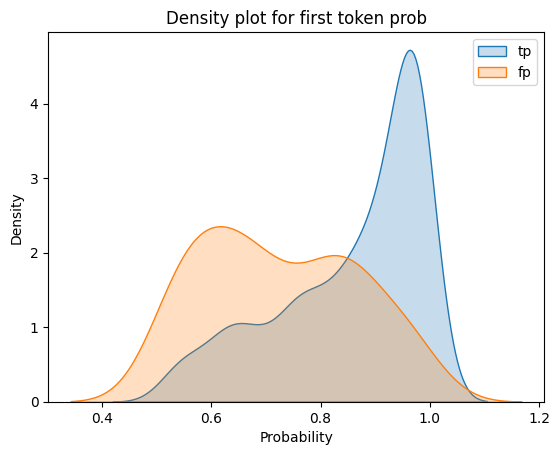

In [31]:
sns.kdeplot(tp_dic['first'], fill=True, label='tp')
sns.kdeplot(fp_dic['first'], fill=True, label='fp')

plt.title('Density plot for first token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

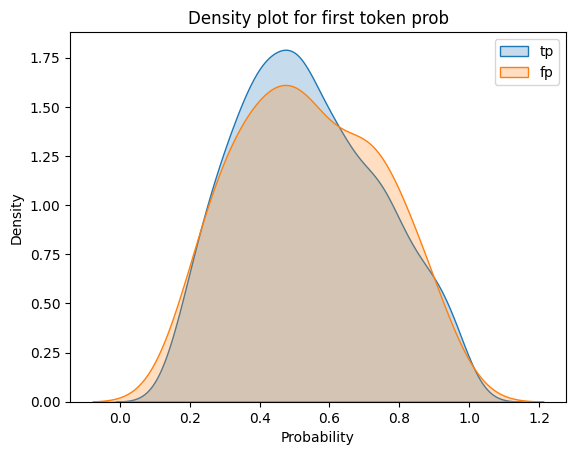

In [32]:
sns.kdeplot(tp_dic['second'], fill=True, label='tp')
sns.kdeplot(fp_dic['second'], fill=True, label='fp')

plt.title('Density plot for first token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

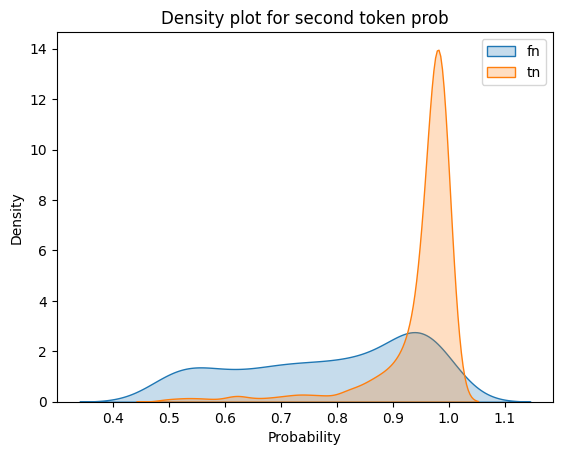

In [33]:
sns.kdeplot(fn_dic['first'], fill=True, label='fn')
sns.kdeplot(tn_dic['first'], fill=True, label='tn')

plt.title('Density plot for second token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

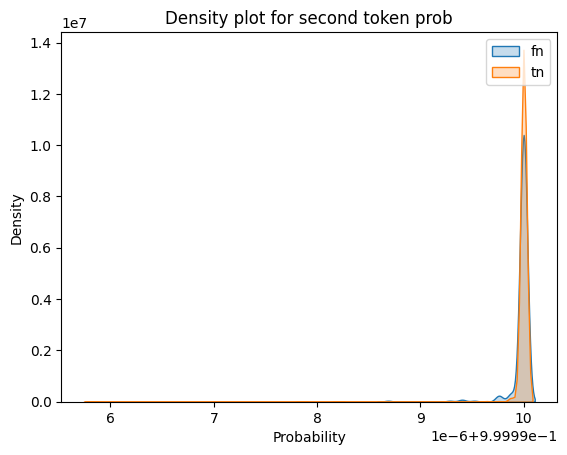

In [34]:
sns.kdeplot(fn_dic['second'], fill=True, label='fn')
sns.kdeplot(tn_dic['second'], fill=True, label='tn')

plt.title('Density plot for second token prob')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()